# Introduction

Today we'll continue on with/finish up **time series**, we'll be introduced to **decision trees** and **random forests**, an ***ensemble method***. I've included a lot of what we covered in our last class so that you can have it all in one place.

## Libraries Used

In [5]:
import os
import sys

import pandas as pd
# import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pandas import Series
import statsmodels.tsa.statespace.sarimax as seas
# from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [6]:
data = pd.read_csv('/Users/MattMecca/Documents/Graduate School/2nd Semester Courses/Applied Statistics & Econometrics II/Data Folder/HF Exch Rate Data.csv')
data.head()



,index,Date,eur_cur,gbp_cur,cny_cur,jpy_cur
0,1,9/18/16,1.1155,1.3002,6.6634,102.20
1,2,9/18/16,1.1156,1.3000,6.6658,102.20
2,3,9/18/16,1.1158,1.3003,6.6684,102.22
3,4,9/18/16,1.1154,1.3004,6.6683,102.26
4,5,9/18/16,1.1158,1.3008,6.6680,102.22


# Time Series in Python

The first hour of this lecture is going to be an adapted version of "Time Series Analysis (TSA) in Python - Linear Models to GARCH" –– http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016. We'll go through it together. I think it'll shed a lot of light on the topics we discussed in our last class.

## White Noise and Random Walks


**White noise** is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially UNcorrelated errors and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it. Below I introduce a convenience function for plotting the time series and analyzing the serial correlation visually. This code was adapted from the blog Seanabu.com

In [7]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

We can model a white noise process easily and output the TS plot for visual inspection. 

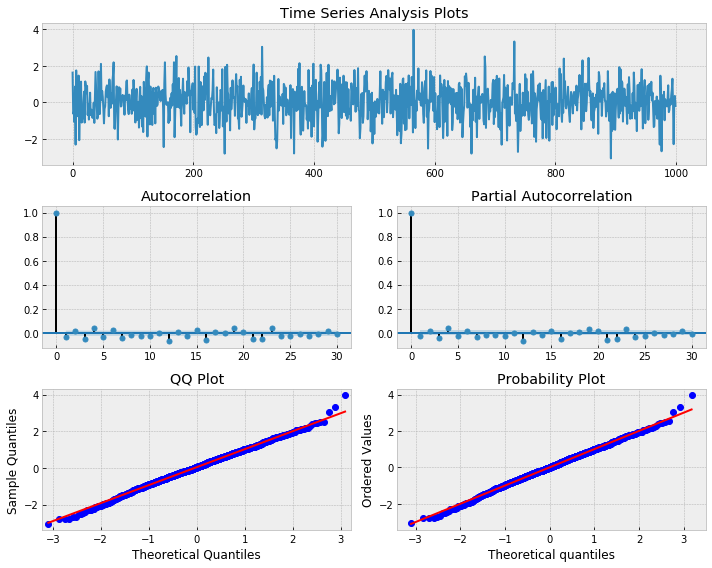

In [8]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

## Random Walk Model

The significance of a random walk is that it is non-stationary because the covariance between observations is time-dependent. If the TS we are modeling is a random walk it is unpredictable.

Let's simulate a random walk using the "numpy.random.normal(size=our_sample_size)" function to sample from the standard normal distribution. 

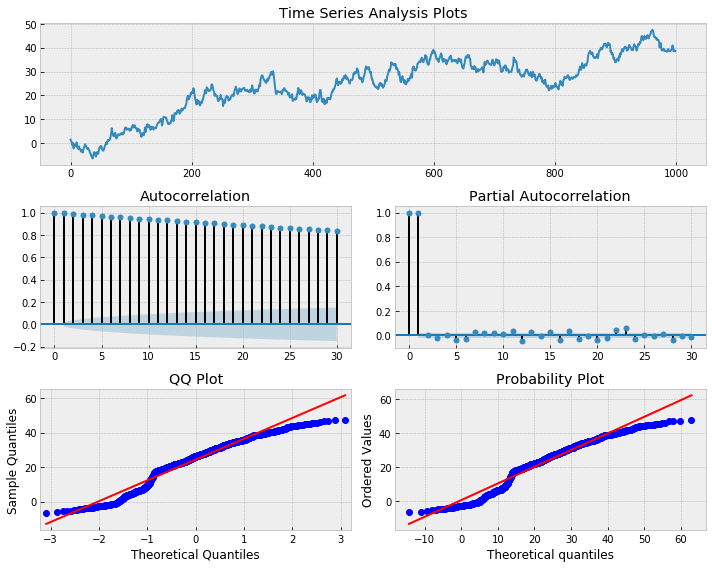

In [9]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. Let's find out if the random walk model is a good fit for our simulated data. Recall that a random walk is xt = xt-1 + wt. Using algebra we can say that xt - xt-1 = wt. Thus the first differences of our random walk series should equal a white noise process! We can use the "np.diff()" function on our TS and see if this holds. 

### First difference of simulated Random Walk series


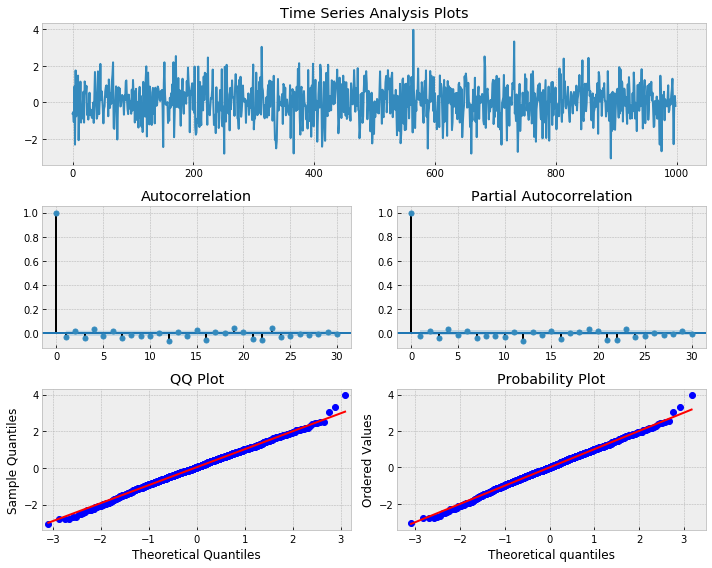

In [10]:
_ = tsplot(np.diff(x), lags=30)


Our definition holds as this looks exactly like a white noise process. What if we fit a random walk to the first difference of EUROs?



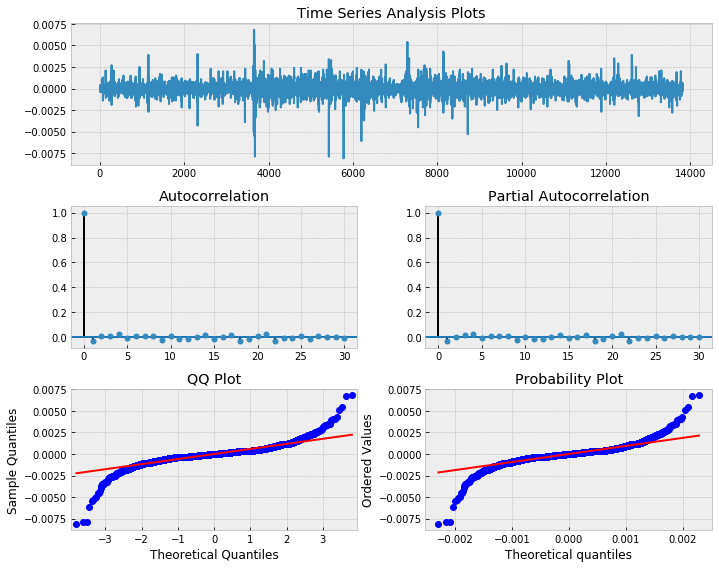

In [11]:
# First difference of SPY prices
_ = tsplot(np.diff(data.eur_cur), lags=30)

It's somewhat similar to white noise. However, notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5?, 16?, 18 and 21. This means that there should be better models to describe the actual price change process. 

### Autoregressive Models - AR(p)


When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive. See board for formula.


When you describe the "order" of the model, as in, an AR model of order "p", the p represents the number of lagged variables used within the model. For example an AR(2) model or second-order autoregressive model is constructed how we wrote it on the board.

Here, alpha (a) is the coefficient, and omega (w) is a white noise term. Alpha cannot equal zero in an AR model. Note that an AR(1) model with alpha set equal to 1 is a random walk and therefore not stationary. 

Let's simulate an AR(1) model with alpha set equal to 0.6

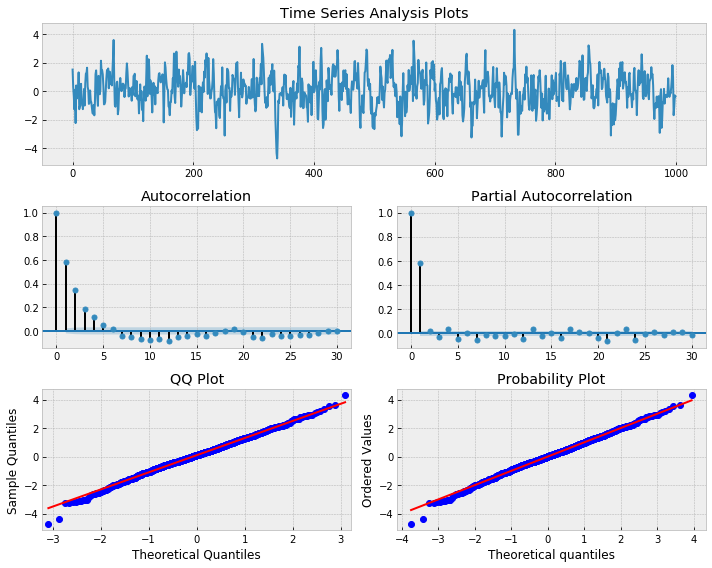

In [13]:
# Simulate an AR(1) process with alpha = 0.6
lags = 30
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

## Paired Programming

Let's try and write an autocorrelation function for the below time series:

In [15]:
time_series = [2, 3, 3.5, 3, 4, 5.5, 6.2, 5.3, 6.9]

ts_mean = np.mean(time_series)

ts_mean

4.377777777777777

In [16]:
def acf(ts = time_series, k = 1, y_bar = ts_mean):
   
   numerator = 0
   denominator = 0

   for t in range(k, len(time_series)):
        numerator += (time_series[t - k] - y_bar)* (time_series[t] - y_bar)

   for t in range(0, len(time_series)):
        denominator += (time_series[t] - y_bar)**2

   acf = numerator / denominator

   return acf

In [17]:
acf(k = 0)

1.0

#### Back to autoregressive models..

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [19]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'.format(a, true_order))

CPU times: user 33.1 s, sys: 838 ms, total: 34 s
Wall time: 18.4 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data.

### Moving Average –– MA(q) models

Reminders:

* AR(p) processes
* I(d) processes


**MA(q)** models are *very similar* to **AR(p)** models. The difference is that the **MA(q)** model is a **linear combination** of **past white noise error terms** as **opposed to** a **linear combo of past observations like the AR(p) model**. The ***motivation for the MA model is that we can observe "shocks" in the error process directly by fitting a model to the error terms***. In an **AR(p) model** these shocks are **observed indirectly** by using the ACF on the series of past observations. The formula for an MA(q) model is:

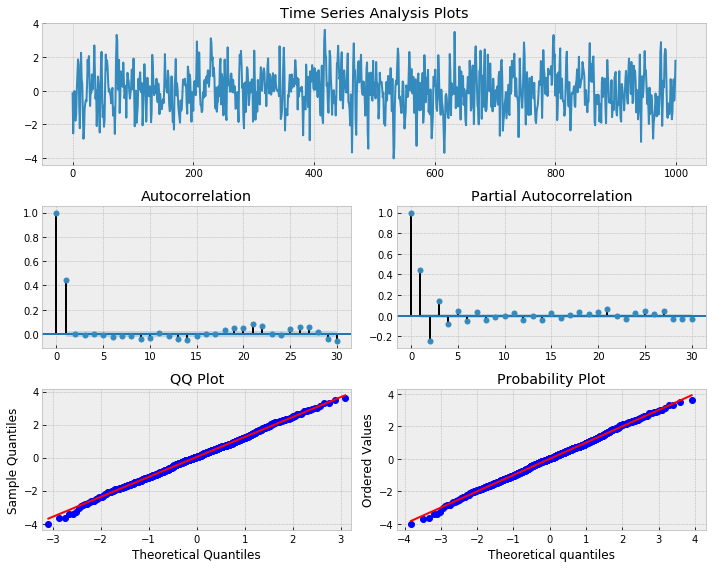

In [20]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

### *NOTE*: we look at the ACF to determine the 'q' of MA(q) processes, the PACF to determine the 'p' of AR(p) processes

The **ACF** shows that lag 1 is significant which indicates that a **MA(1) model may be appropriate** for our simulated series. Regardless, we can now attempt to fit a MA(1) model to our simulated data. We can use the same statsmodels "ARMA()" function specifying our chosen orders. We call on its "fit()" method to return the model output. 

In [17]:
# Fit the MA(1) model to our simulated time series data
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1448.721
Method:                           mle   S.D. of innovations              1.030
Date:                Tue, 18 Sep 2018   AIC                           2901.441
Time:                        16:37:36   BIC                           2911.257
Sample:                             0   HQIC                          2905.172
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6158      0.026     23.947      0.000       0.565       0.666
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6240           +0.0000j            1.6240            0.5000
-----------------------------------------------------------------------------
"""

The model was able to correctly estimate the lag coefficent as 0.58 is close to our true value of 0.6. Also notice that our 95% confidence interval does contain the true value. Let's try simulating an MA(3)  process, then use our ARMA function to fit a third order MA model to the series and see if we can recover the correct lag coefficients (betas). Betas 1-3 are equal to 0.6, 0.4, and 0.2 respectively.

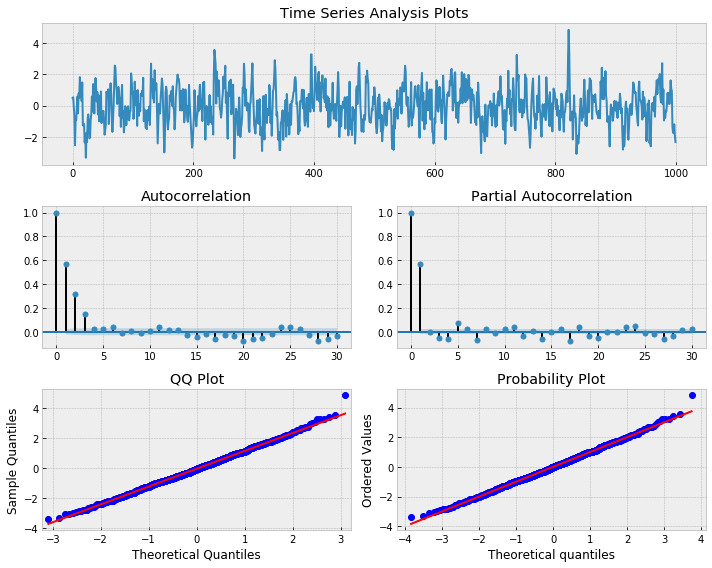

In [21]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [20]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1389.808
Method:                           mle   S.D. of innovations              0.971
Date:                Tue, 18 Sep 2018   AIC                           2787.616
Time:                        16:37:46   BIC                           2807.247
Sample:                             0   HQIC                          2795.077
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5673      0.031     18.393      0.000       0.507       0.628
ma.L2.y        0.3662      0.034     10.621      0.000       0.299       0.434
ma.L3.y        0.1966      0.030      6.539      0.000       0.138       0.255
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.0234           -1.6735j            1.6736           -0.2522
MA.2           -0.0234           +1.6735j            1.6736            0.2522
MA.3           -1.8162           -0.0000j            1.8162           -0.5000
-----------------------------------------------------------------------------
"""

The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.6, 0.4, and 0.3. Now let's try fitting an MA(3) model to the SPY's log returns. Keep in mind we do not know the true parameter values.

## Quick Question

What's the difference between an AR(1) process and an MA(1) process?

## Autoregressive Moving Average Models - ARMA(p, q)


As you may have guessed, the ARMA model is simply the merger between AR(p) and MA(q) models. Let's recap what these models represent to us from a quant finance perspective: 

AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets. 

MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

"For a set of products in a grocery store, the number of active coupon campaigns introduced at different times would constitute multiple 'shocks' that affect the prices of the products in question."


## Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

**ARIMA** is a **natural extension** to the class of **ARMA models**. As previously mentioned many of our TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of a Guassian random walk and proved that it equals white noise. Said another way, we took the nonstationary random walk and transformed it to stationary white noise by first-differencing.

Without diving too deeply into the equation, just know the "d" references the number of times we are differencing the series. A side note, in Python we must use np.diff() function if we need to difference a series more than once. The **pandas** functions **DataFrame.diff()/Series.diff()** only takes the first difference of a dataframe/series and does not implement the recursive differencing needed in TSA.  

In the following example, we iterate through a non-trivial number of combinations of (p, d, q) orders, to find the best ARIMA model to fit SPY returns. We use the AIC to evaluate each model. The lowest AIC wins. 

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anacon

aic: -166487.84918 | order: (4, 1, 3)


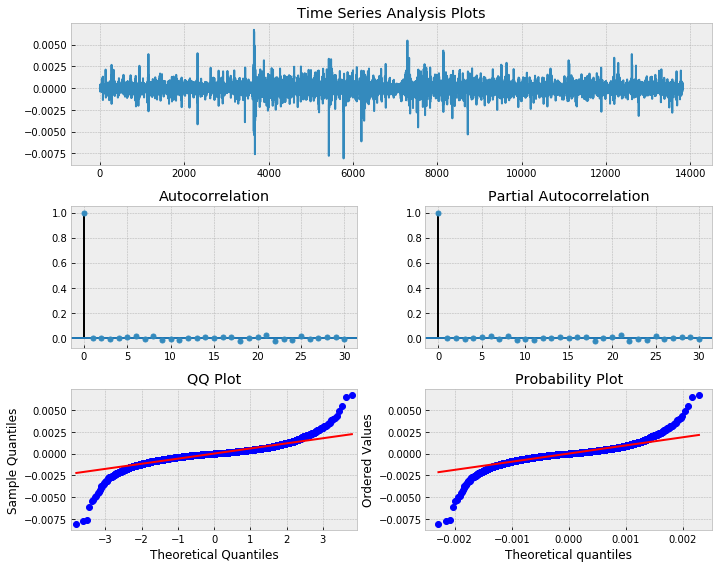

In [22]:
# Fit ARIMA(p, d, q) model to Euro numbers, pick best order and
# final model based on aic. This model test is derived from the
# statsmodels module

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4] range for our AR(p) and MA(q) processes
d_rng = range(2) # [0,1] range for or I(d) process
for p in pq_rng: # Number of LAGS that we include
    for d in d_rng: # Number of times we DIFFERENCE series # Number of 
        for q in pq_rng: # Number of ERROR TERMS we include
            try:
                tmp_mdl = smt.ARIMA(data.eur_cur, order=(p, d, q)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except: continue # Continues through model combinations if error is thrown


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -166487.84918 | order: (4, 1, 3)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)



Below, we plot the model residuals. ***Note*** that this ARIMA model has not explained the **conditional volatility** in the series! This could be done using an **ARCH** or **GARCH** model, something that we most likely will not get around to covering.

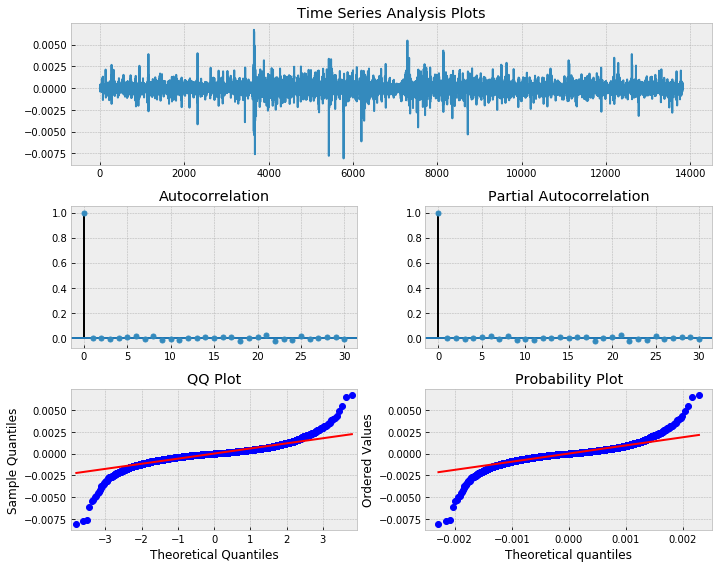

In [23]:
_ = tsplot(best_mdl.resid, lags=30) # Plotting the RESIDUALS


### Quick Question

What about **seasonality**? How could we account for that? And what about other variables? Like interest rate and the like?

## SARIMAX

This content will follow https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/ closely.

**Seasonal Autoregressive Integrated Moving Average**, **SARIMA** or **Seasonal ARIMA**, is an extension of ARIMA that explicitly supports univariate time series data with a **seasonal component**.

It adds three new hyperparameters to specify the **autoregression (AR)**, **differencing (I)** and **moving average (MA)** for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

* "A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA […] The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period."

— Page 242, Forecasting: principles and practice, 2013.

## How to Configure SARIMA

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

### Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

* **p**: Trend autoregression order.
* **d**: Trend difference order.
* **q**: Trend moving average order.

### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* **P**: Seasonal autoregressive order.
* **D**: Seasonal difference order.
* **Q**: Seasonal moving average order.
* **m**: The number of time steps for a single seasonal period.

Together, the notation for an SARIMA model is specified as:

In [ ]:
SARIMA(p,d,q)(P,D,Q)m

Importantly, the **'m'** parameter **influences** the **'P'**, **'D'**, and **'Q'** parameters. 

For example, an **'m'** of 12 for monthly data *suggests a **yearly** seasonal cycle*.

A **P = 1** would make use of the first seasonally offset observation in the model, e.g. t - (m * 1) or t - 12 (regressing on the observation from one year ago today). A P = 2, would use the last two seasonally offset observations t-(m * 1), t-(m * 2), or t - 12 and t - 24 (makes sense if effects are persistent).

Similarly, a **D** of **1** would calculate a **first order seasonal difference** (differencing would be **y_t - y_(t-12)** when m = 12, e.g.) and a **Q = 1** would use a **first order errors** in the model (e.g. **moving average**).

* "A seasonal ARIMA model uses differencing at a lag equal to the number of seasons (s) to remove additive seasonal effects. As with lag 1 differencing to remove a trend, the lag s differencing introduces a moving average term. The seasonal ARIMA model includes autoregressive and moving average terms at lags."

— Page 142, Introductory Time Series with R, 2009.

The trend elements can be chosen through careful analysis of ACF and PACF plots looking at the correlations of recent time steps (e.g. 1, 2, 3).

Similarly, ACF and PACF plots can be analyzed to specify values for the seasonal model by looking at correlation at seasonal lag time steps.

* "Seasonal ARIMA models can potentially have a large number of parameters and combinations of terms. Therefore, it is appropriate to try out a wide range of models when fitting to data and choose a best fitting model using an appropriate criterion …"

— Pages 143-144, Introductory Time Series with R, 2009.

### Loading, Dividing, and Plotting our Quarterly Dataset 

In [36]:
data1 = pd.read_csv('/Users/MattMecca/Documents/Graduate School/Data Folder/FormattedData.csv')
data1.head()


,Year,Quarter,govb,corp,tbill,cpi,vwr,vwp,ewr,ewp,gcnq,gcsq,pop
0,1959,3,-0.0038,-0.0057,0.0075,0.0046,-0.0235,-0.0309,-0.0319,-0.0395,608.1,692.9,177.5
1,1959,4,-0.0129,0.0203,0.0089,0.0034,0.0638,0.0541,0.0605,0.0501,612.2,702.6,178.3
2,1960,1,0.0609,0.0432,0.0097,0.0000,-0.0671,-0.0749,-0.0550,-0.0630,612.1,711.0,179.7
3,1960,2,0.0152,0.0097,0.0071,0.0080,0.0408,0.0321,0.0271,0.0179,619.3,717.3,180.3
4,1960,3,0.0375,0.0312,0.0046,0.0011,-0.0500,-0.0578,-0.0435,-0.0517,615.0,717.1,181.1


#### Variable Index

* **Year**:	year recorded
* **Quarter**:	year's quarter
* **gcnq**:	real quarterly nondurables expenditure
* **gcsq**:	real quarterly services expenditure
* **pop**:	population
* **govb**:	index of government bond returns
* **corp**:	index of corporate bond returns
* **tbill**:	
* **cpi**:	consumer price index
* **vwr**:	value-weighted market return
* **vwp**:	value-weighted return with price only
* **ewr**:	equally-weighted return
* **ewp**:	equally-weighted return with price only

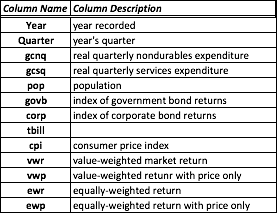


0   -0.0319
1    0.0605
2   -0.0550
3    0.0271
4   -0.0435
Name: ewr, dtype: float64


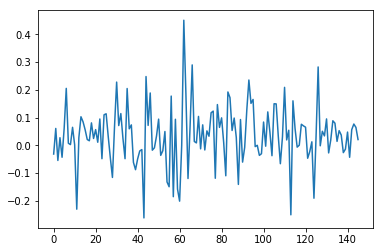

In [37]:
import matplotlib.pyplot as pyplot

y = data1.ewr # 'ewr' the EQUALLY WEIGHTED RETURN. It comes as a
              # PERCENTAGE CHANGE and thus (most likely) does not
              # require differencing
print(y.head())
y.plot()
pyplot.show()

Take a note of what happens in quarters **50** to **70**. The **mean** remains relatively constant, or **STATIONARY**, but it seems that the return's **variance** becomes a bit unweildy, or **NONSTATIONARY**. It is not nonstationary in the strict sense. I.e., it would check out when using a **Augmented Dickey-Fuller test** or a **Phillips-Perron test**, but it wouldn't pass the *eye* test.

What we're seeing here is **conditional heteroscedasticity** of our **residual's**, or **error term's**, variance. In other words, **the absolute value of our residuals change depending on where we are in the time series**. They'll **vary** based on time, sure, but that variation **depends** on the specific time in which we're in. We can account for this in our regression equation by including **lagged variance** and **lagged error** terms (or sigma^2_(t-1)). We do just that when using a **GARCH**, or **G**eneralized **A**utoregressice **C**onditionally **H**eteroscedastic, **Model**. 

Simply put, a **GARCH(p, q)** is an **ARMA(p, q)** model applied to the **variance of a time series**; i.e., it has an **autoregressive term** and a **moving average term**. The **AR(p)** models the **variance of the residuals (squared errors)** or *simply our time series squared*. The **MA(q)** portion models the **variance** of the process. See the board for the basic GARCH(1, 1) formula. We won't go into detail on GARCH(1,1) models here, but they are worth considering, especially if it's stock, investment, etc. **returns** that you plan on modeling. To get started, you can take a look at the link to the same time series tutorial that I mentioned before:

http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARCH

Equal weight is a type of weighting that gives the same weight, or importance, to each stock in a portfolio or index fund, and the smallest companies are given equal weight to the largest companies in an equal-weight index fund or portfolio.

Observations: 145
Training Observations: 114
Testing Observations: 29


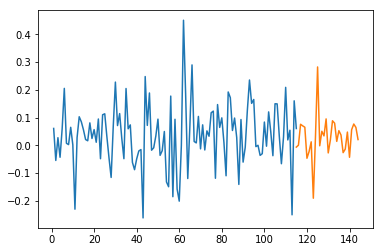

In [38]:
train_size = int(len(y) * 0.80)
train_y, test_y = y[1:train_size], y[train_size:len(y)]
# We have to shorten all time series by 1 because we need to 
# DIFFERENCE one of our time series (CPI) in order to make that
# time series STATIONARY
print('Observations: %d' % (len(y) - 1))
print('Training Observations: %d' % (len(train_y) - 1))
print('Testing Observations: %d' % (len(test_y) - 1))

pyplot.plot(train_y)
pyplot.plot([None for y in train_y] + [y for y in test_y])
# Accounts for the TRAINING set and PLOTS the TEST set. We can see
# that while the first list comprehension plots the TRAINING SET, it
# OUTPUTS NOTHING (or None). The second list comprehension outputs
# each observation of the TEST SET, colored orange.

pyplot.show()

### Difference Between Additive and Multiplicative Seasonality and Defining our Model

**Additive seasonality** shows as a consistent pattern to our time series while **multiplicative seasonality** shows as a widening or diminishing pattern to our time series. (See board and see the link below: https://www.youtube.com/watch?v=85XU1T9DIps)

The implementation is called **SARIMAX** instead of SARIMA because the **“X”** addition to the method name means that the implementation also supports **exogenous variables**.

These are parallel time series variates that are not modeled directly via AR, I, or MA processes, but are made available as a weighted input to the model.

**Exogenous variables** are optional can be specified via the “exog” argument. They can be ***anything*** that you'd like to factor in as a **predictor** or **control for**.

The trend and seasonal hyperparameters are specified as 3 and 4 element tuples respectively to the “order” and “seasonal_order” arguments.

These elements must be specified.

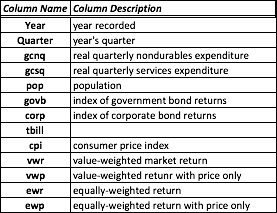

## Defining our Model

In [39]:
X['cpi'] = X['cpi'].astype(float)


In [40]:
# Specify EXOGENOUS VARIABLES
X = data1[['govb', 'corp', 'cpi']]
X['cpi'] = X['cpi'].astype(float)
X1 = X['govb']
X2 = X['corp']
X3 = X['cpi']
print(X1.head(), '\n')
print(X2.head(), '\n')
print(X3.head())




0   -0.0038
1   -0.0129
2    0.0609
3    0.0152
4    0.0375
Name: govb, dtype: float64 

0   -0.0057
1    0.0203
2    0.0432
3    0.0097
4    0.0312
Name: corp, dtype: float64 

0    0.0046
1    0.0034
2    0.0000
3    0.0080
4    0.0011
Name: cpi, dtype: float64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Observations: 145
Training Observations: 114
Testing Observations: 29


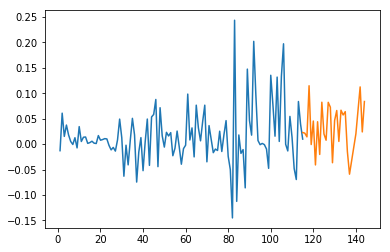

In [45]:
train_X1, test_X1 = X1[1:train_size], X1[train_size:len(y)]
# We have to shorten all time series by 1 because we DIFFERENCE
# one of our time series
print('Observations: %d' % (len(y) - 1))
print('Training Observations: %d' % (len(train_y) - 1))
print('Testing Observations: %d' % (len(test_y) - 1))

train_X2, test_X2 = X2[1:train_size], X2[train_size:len(y)]
train_X3, test_X3 = X3[0:train_size], X3[train_size:len(y)]

pyplot.plot(train_X1)
pyplot.plot([None for X1 in train_X1] + [X1 for X1 in test_X1])
pyplot.show()

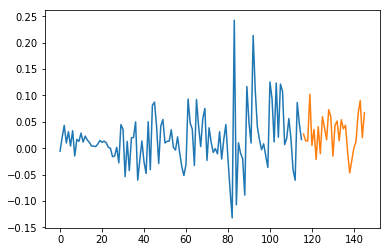

In [92]:
pyplot.plot(train_X2)
pyplot.plot([None for X2 in train] + [X2 for X2 in test_X2])
pyplot.show()

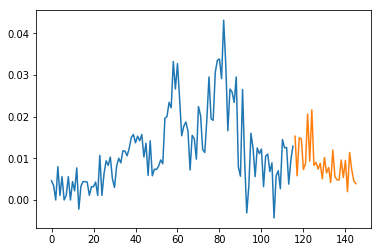

In [93]:
pyplot.plot(train_X3)
pyplot.plot([None for X3 in train_X3] + [X3 for X3 in test_X3])
pyplot.show()

Without running the **Augmented Dickey Fuller test**, or (**ADF**), it looks like the **CPI time series** is **NONSTATIONARY**. I'm going to assume that here.

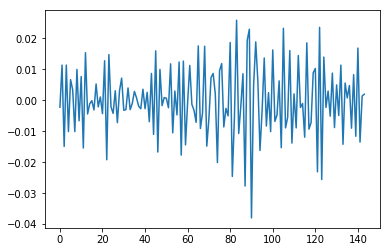

In [46]:
D_X3 = np.diff(X3)
plt.plot(np.diff(D_X3))

While there might be some **conditional heteroscedasticity** here, it does look like our time series is now **STATIONARY**.

In [47]:
train_D_X3, test_D_X3 = D_X3[0:115], D_X3[115:len(y)]


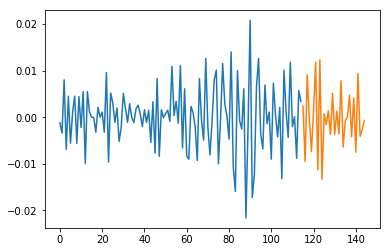

In [48]:
pyplot.plot(train_D_X3)
pyplot.plot([None for D_X3 in train_D_X3] + [D_X3 for D_X3 in test_D_X3])
pyplot.show()

#### I wrote most of this script on a plane, and so I wasn't able to look up the SARIMAX package for model selection criteria (as I did for ARIMA, e.g.). I thus chose p, q, d, and P, Q, D somewhat randomly. Better would be to look up a function that would help you when choosing these parameters (i.e., it would most likely contrast the smallest AIC/BIC (which each quantify how well our model 'fits' our data) over a range of different parameters. 

In [49]:
train_y = pd.DataFrame(train_y).reset_index(drop = True)
train_X1 = pd.DataFrame(train_X1).reset_index(drop = True)
train_X2 = pd.DataFrame(train_X2).reset_index(drop = True)
train_D_X3 = pd.DataFrame(train_D_X3, columns = ['D_cpi']).reset_index(drop = True)

test_y = pd.DataFrame(test_y).reset_index(drop = True)
test_X1 = pd.DataFrame(test_X1).reset_index(drop = True)
test_X2 = pd.DataFrame(test_X2).reset_index(drop = True)
test_D_X3 = pd.DataFrame(test_D_X3, columns = ['D_cpi']).reset_index(drop = True)


In [50]:
exog_vars_train = pd.concat([train_X1, train_X2, train_D_X3], axis = 1)
exog_vars_test = pd.concat([test_X1, test_X2, test_D_X3], axis = 1)
exog_vars_train.head()



,govb,corp,D_cpi
0,-0.0129,0.0203,-0.0012
1,0.0609,0.0432,-0.0034
2,0.0152,0.0097,0.0080
3,0.0375,0.0312,-0.0069
4,0.0182,0.0041,0.0045


In [52]:
# Define model configuration
my_order = (4, 0, 3) # The ARIMA aspect of our SARIMAX, or the
# (p, d, q) parameters (corresponding to AR(p), I(d), and MA(q))

my_seasonal_order = (1, 0, 1, 4) # The S, or seasonality aspect
# of our SARIMAX, or the (P, D, Q)_m parameters (meaning y_(t-4)
# and e_(t-4) are now tied into the model, as the data is quarterly,
# and thus m = 4)

# Define model

model = seas.SARIMAX(train_y, exog = exog_vars_train, order = my_order, seasonal_order = my_seasonal_order)



## Fitting our Model

Once the model is created, it can be fit on the training data.

The model is fit by calling the fit() function.

Fitting the model returns an instance of the SARIMAXResults class. This object contains the details of the fit, such as the data and coefficients, as well as functions that can be used to make use of the model.

In [53]:
model_fit = model.fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Making our Prediction

Once fit, the model can be used to make a forecast.

A forecast can be made by calling the **forecast()** or the **predict()** functions on the **SARIMAXResults object** returned from calling fit.

The **forecast()** function takes a single parameter that specifies the number of out of sample time steps to forecast, or assumes a one step forecast if no arguments are provided.


In [162]:
?model.predict

In [54]:
# One step ahead forecast
yhat = model_fit.predict(params = train_y, exog = exog_vars_test, start=(len(train_y) - 1), end=(len(train_y) - 1))
# This last piece of code needs some work –– not executing properly


### Decision Tree Regression vs Decision Tree Classification

The primary difference between these two is that, with **decision tree regression**, the response, or our 'y', variable is **CONTINUOUS** (e.g., 1.8223, 5, -123.340940, ...); with **decision tree classification**, the response, or our 'y', variable is **CATEGORICAL**, or **DISCRETE** (e.g., Yes, No, Blue, Green, etc.) –– they're allocated to one of any number of *buckets*.



## The Gini Index, Cross-Entropy, and the Misclassification Error

See board for ***PROOF*** that the **Misclassification Error** is bounded above by the **Gini Index**.

* Proofs are why we ought to "take the mathematician's word for it." Mathematicians, generally speaking, are skeptical people. If there's a widely distributed **THEOREM** in mathematics, you can bet that its proven time and time again (and in more than a few  ways). There are times that we can reason and make sense of how and why certain formulas work, but, for the most part, we are not going to try and work out every theorem's proof; we are simply going to "take the mathematician's word for it."

## Paired Programming

With the below data set, let's write a function that calculates the Gini Index.

In [ ]:
new_data = [(0.33, 0.67), (0.22, 0.78), (0.01, 0.99), (0.86, 0.14)]

### Decision Tree Regression

In [55]:
#### Decision Tree Regression ####

### Regression trees a bit more complicated than classification trees. With it,
### we partition our data into groups that, hopefully, adds some value to the  
### way we want to group our obs. points. The algorithm stops itself when
### finding that the next poss. partition adds no significant value, or information,
### to our system of data. The partitions are referred to as terminal LEAVES 
### (like what we call the last nodes of a decision tree in game theory). At the
### end, we take the average of y for EACH TERMINAL leaf (based on location of
### (x1, x2)). The regression algorithm would then predict the value of y to be  
### identical to the average y of whatever terminal LEAF its (x1, x2) lands it 
### in. The decision tree regression model is NONCONTINUOUS

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [59]:
## Importing the dataset ##
dataset = pd.read_csv('/Users/MattMecca/Documents/Data Science Material/Machine Learning Template Folder/Part 2 - Regression/Section 8 - Decision Tree Regression/Position_Salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values


In [60]:
## Splitting the Dataset into the Training set and Test set ##
"""from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)"""

## Feature Scaling ##
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""

## Fitting the Decision Tree Regression Model to the Dataset ##
from sklearn.tree import DecisionTreeRegressor 
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X, y)

## Predicting a New Result ##
y_pred = regressor.predict(6.5)


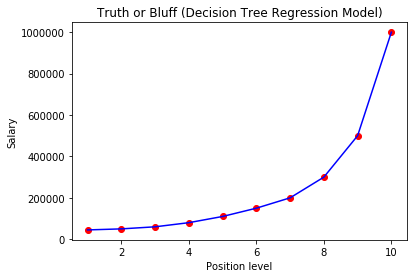

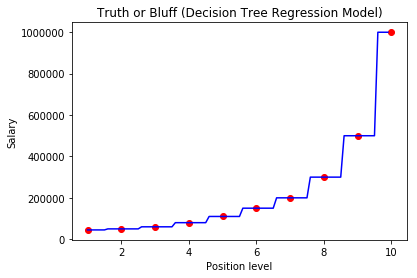

In [61]:
## Visualising FALSE Decision Tree Regression Results ##
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
plt.title('Truth or Bluff (Decision Tree Regression Model)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# This code DOES NOT account for the fact that the Decision Tree regression
# model is NOT continuous (note the OVERfitting). We therefore need to revise it


## Visualising the ACCURATE Decision Tree Regression results (i.e., for higher 
## resolution and smoother curve) ##
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Decision Tree Regression Model)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()
# Here, we can see what the intervals are and, quite clearly, that the values
# are dictated by that interval's average


## And so, again: ##
y_pred = regressor.predict(6.5)

# We see that, b/c there's only one obs. for each interval and b/c the avg.s 
# don't change even when the code is revised, our predicted value is, once
# again, 150000


### Decision Tree Classification

In [62]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 22 16:26:40 2017

@author: MattMecca
"""

#### Decision Tree Classification ####

### When splitting, or parsing, the data, the algorithm that engineers Decision 
### Trees aims to MAXIMIZE the # of one set of data points in one area (say, 
### red data points) and the # of one set of data points in another area (say, 
### green data points); in other words, the split is trying to MINIMIZE entropy
### here.

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [65]:
## Importing the dataset ##
dataset = pd.read_csv('/Users/MattMecca/Documents/Data Science Material/Machine Learning Template Folder/Part 3 - Classification/Section 19 - Decision Tree Classification/Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values


In [66]:
## Splitting the Dataset into the Training Set and Test Set ##
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [67]:
## Feature Scaling ##
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Strictly speaking we do NOT have to apply feature scaling here as Decision 
# Trees are NOT algorithms dependent on EUCLIDEAN distance
# We only scale here because we want to PLOT our decision tree with a higher
# resolution (it plots a great deal faster when scaling). Note again that 
# decision trees do not need to be scaled as their algorithm does NOT take
# Euclidean distance into account


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [69]:
## Fitting the Decision Tree to the Training Set ##

from sklearn.tree import DecisionTreeClassifier # This particular classifier is
# based on / determined by ENTROPY, or the INFORMATION GAIN
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

## Predicting the Test Set Results ##
y_pred = classifier.predict(X_test)



In [70]:
## Making the Confusion Matrix ##

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) 
cm # We see here that there exists only NINE incorrect predictions


array([[62,  6],
       [ 3, 29]])

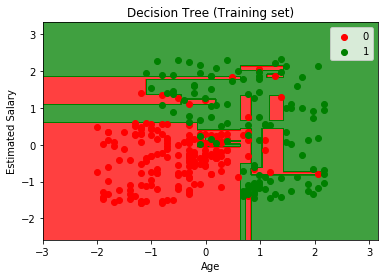

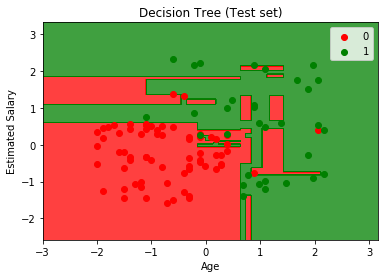

In [71]:
## Visualising the Training Set Results ##

from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Decision Tree (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()
# We can see here that the plot of our decision tree is very cleanly partitioned,
# far different than our Naive Bayes' or other classifiers. It shows this way b/c
# of the way the Decision Tree is determined, using splits in order to minimize
# entropy (or to MAXIMIZE information). What's scary, though, here is that there
# were very obvious signs of overfitting. The model, almost by luck, works well
# with the Test set. We should note, though, that that TYPICALLY WILL NOT BE 
# THE CASE


## Visualising the Test Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Decision Tree (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

## Random Forest Regression

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 13 15:15:35 2017

@author: MattMecca
"""

#### Random Forest Regression ####

### Random Forest is a version of ENSEMBLE LEARNING, which is when you take MULTIPLE
### algorithms, or the same algorithm multiple times, and you put them together
### to make something much more powerful than the original. It works as follows: 
###
### Step 1: Pick at random K data points from the Training set
###
### Step 2: Build the DECISION TREE associated to these K data points
###
### Step 3: Choose the number of Ntree trees you want to build and repeat steps  
###         1 & 2
###
### Step 4: For a new data point, make EACH one of your Ntree trees predict the
###         value of Y for the data point in question and assign the new data
###         point the avg. across ALL of the predicted Y values
### 
### By step 4, we see that we're no longer predicting based on one tree but rather
### we're predicting based on a FOREST of trees (taking the average of our est.s
### of y), and that, in theory, improves the accuracy of our prediction
###
### ENSEMBLE algorithms like this more stable typically because, while a changes   
### in our dataset would might impact one tree, it would be incredibly hard for
### that change to affect a FOREST of trees in the same way 
###
### A good EXAMPLE of an ensemble method is recording people's guesses for how 
### many marbles might be in a jar, recording a hundred or even a thousand obs.s,
### and then take the median or the avg. of the obs.s before making your guess
###
### Random Forest regression is simply the average of the diff. trees in the 
### forest

#### Regression Template ####

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
## Importing the dataset ##
dataset = pd.read_csv('Position_Salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values



In [ ]:
## Splitting the Dataset into the Training set and Test set ##
"""from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)"""


## Feature Scaling ##
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""


## Fitting the Random Forest Regression to the Dataset ##
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0) 
# We're starting with TEN trees in our Random Forest
regressor.fit(X, y)





In [ ]:
## Predicting a New Result ##
y_pred = regressor.predict(6.5)
# We see that with n_estimators = 10, we have more steps in our reg. eq., and 
# thus a more accurate prediction: 167000




In [ ]:
## Visualising the Random Forest Regression Results (for higher resolution and smoother curve) ##
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()
# When we run our reg. w/ n_estimators = 10, we see that there are MORE STEPS
# in our discrete dist.-like, noncontinuous STAIRS. Each straight horizontal 
# line separated by the vertical lines which connect where the Random Forest 
# took the avg. of the Decision Trees and come up with an estimate (top-most 
# end of every vertical line)

# More trees, HOWEVER, does not always mean more steps. We have to remember 
# that we are calculating an average here, and so the more Trees we add the more
# we converge to some asymptotic average. After a point, the line of best fit
# will remain unchanged, no matter the increase in n_estimators   


## What happens when we have a Forest of 100 Trees?

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
# 100 trees in our Random Forest now
regressor.fit(X, y)

y_pred = regressor.predict(6.5)

X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# We see here that prediction is DRAMATICALLY improved. Our prediction is now
# 158300, far closer to 160000 than 167000. 

# If we up the ante to 300 trees?

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 0) 
# 300 trees in our Random Forest now
regressor.fit(X, y)

y_pred = regressor.predict(6.5)

X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# We see here that our estimate is even MORE accurate here. 160333.333 is 
# closer to 160000 than 158333 was, and so we an improvement as n tends to
# infinity

## Random Forest Classification

In [72]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 22 19:33:39 2017

@author: MattMecca
"""

#### Random Forest Classifier ####

### Random Forests use a method called ENSEMBLE LEARNING, which is when you take
### multiple machine learning algorithms and put them together to create one,
### BIGGER machine learning algorithm. That final ML algorithm, therefore, is using
### or LEVERAGING many different other ML algorithms. The algos we'll be combining
### here are those of our DECISION TREES. Basically, you start out with one tree
### and you build another tree and then another and so on, and EACH one of those 
### trees is being built on a randomly selected SUBSET of our data( or PREDICTORS); and even 
### though, alone, each one of those trees might not be ideal, overall (or on 
### average) they perform VERY well. That is a major ADVANTAGE of this algorithm.
### It's kind of leveraging the power of the CROWD, so to speak. I.e., instead 
### of relying on one tree, it's taking the majority "vote" and deciding the 
### classification based on that. E.g., take ANY point on the plot. If it is 
### GREEN, then the Random Forest counted which trees voted YAY for the predicted 
### region and the Random Forest counted which trees voted NAY for the predicted 
### region and the YAYs had it (e.g. 6 Trees said yes vs 4 Trees said no)


### Random Forest is like an ARMY of decision trees, w/ each one predicting a 
### result, and then, based on a majority vote, the ULTIMATE prediction is made

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [73]:
## Importing the dataset ##
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values


In [105]:
dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [74]:
## Splitting the Dataset into the Training Set and Test Set ##
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [75]:
## Feature Scaling ##
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [98]:
## Fitting Random Forest Classification to the Training Set ##
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
# We can LIMIT overfitting by playing around with the # of trees in our model
### Entropy is a notion in PHYSICS that represents in some way the disorder of
### particles. We're saying here that after a split, say, the more homogeneous
### are our NEW GROUPS of users and the more that our entropy is REDUCED. And 
### so here we're saying that the particles, e.g., are users and the more 
### homogeneous that group of users, the less disorder and the MORE our data's
### entropy is reduced 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [99]:
## Predicting the Test Set Results ##
y_pred = classifier.predict(X_test)


In [100]:
## Making the Confusion Matrix ##
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm # Note that there are only EIGHT obs.s INcorrectly classified here. This is 
# fewer than our decision tree model 


array([[64,  4],
       [ 4, 28]])

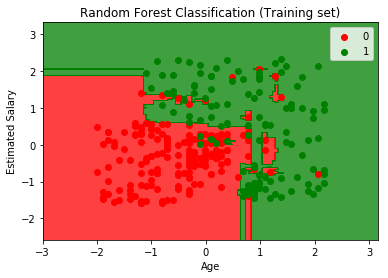

In [101]:
## Visualising the Training Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()
# There is most definitely some over fitting going on here


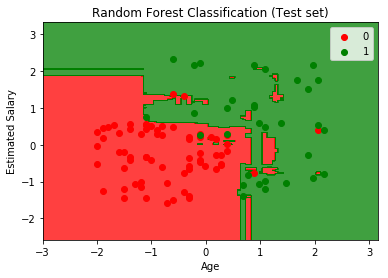

In [102]:
## Visualising the Test Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show() 
# When choosing a correct classifier, we're constantly torn b/w accuracy and 
# PREVENTING overfitting
